BBB Project Part 2
===

- Shows performance of bayes by backprop, a method using Variational Inference on a network

## Import files: same as other BBB project parts

In [27]:
# Add local folders to path
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [28]:
from collections import OrderedDict

import pymc3 as pm
import theano
import theano.tensor as tt

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import mode
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

%matplotlib inline

In [29]:
print('PyMC3 v{}\nTheano v{}'.format(pm.__version__,theano.__version__))

PyMC3 v3.5
Theano v1.0.3


In [30]:
# Set random seeds
np.random.seed(42)
pm.set_tt_rng(42)

In [31]:
# Avoid warnings on batches below
from warnings import filterwarnings
filterwarnings('ignore')

In [32]:
# Use tensorflow to import image datasets
import tensorflow as tf

reshape_train_imgs = lambda img : img.reshape(img.shape[0],-1)
imgvec2img = lambda vec : vec.reshape((np.sqrt(vec.shape[0]).astype(int),np.sqrt(vec.shape[0]).astype(int)))
floatX = theano.config.floatX

dataset = 'fashion_mnist'

if dataset == 'mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train,X_test = reshape_train_imgs(X_train),reshape_train_imgs(X_test)
    label_dict = OrderedDict({i:str(i) for i in range(10)})
    
    X_train = X_train.astype(floatX)/255
    y_train = y_train.astype(np.int)
    X_test = X_test.astype(floatX)/255
    y_test = y_test.astype(np.int)
    
    n_output = len(label_dict)
    
elif dataset == 'fashion_mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    X_train,X_test = reshape_train_imgs(X_train),reshape_train_imgs(X_test)
    label_dict = OrderedDict({0: 'T-shirt/top',
                              1: 'Trouser',
                              2: 'Pullover',
                              3: 'Dress',
                              4: 'Coat',
                              5: 'Sandal',
                              6: 'Shirt',
                              7: 'Sneaker',
                              8: 'Bag',
                              9: 'Ankle boot'})
    X_train = X_train.astype(floatX)/255
    y_train = y_train.astype(np.int)
    X_test = X_test.astype(floatX)/255
    y_test = y_test.astype(np.int)
    
    n_output = len(label_dict)

(n_train,n_input) = X_train.shape
print("N Input for {} = {}".format(dataset,n_input))

N Input for fashion_mnist = 784


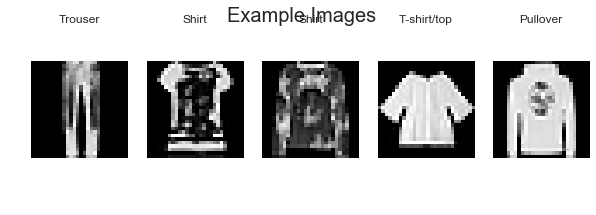

In [33]:
# PLot random subset of images
n_plot_samples = 5
rand_samps = np.random.choice(X_train.shape[0],size=n_plot_samples)

figsize = (10,3); fontsize = 16;
f, axs = plt.subplots(1,n_plot_samples,sharex=True,figsize=figsize);
for rs,ax in zip(rand_samps,axs):
    ax.imshow(imgvec2img(X_train[rs]),cmap='gray');
    ax.axis('off')
    ax.set_title(label_dict[y_train[rs]]);
    sns.despine();
f.suptitle("Example Images",fontsize=fontsize+4);

Use %load magic here to load `bbb_nn.py`. Delete are re-run a cell as below for updates:
```python
%load bbb_nn.py
```

In [9]:
# %load bbb_nn.py
def construct_nn(ann_input, ann_output, n_input, n_output, n_train, n_hidden_1=64, n_hidden_2=32):
    
    # Initialize random weights between each layer
    init_w_1 = np.random.randn(n_input, n_hidden_1).astype(theano.config.floatX)
#     init_w_2 = np.random.randn(n_hidden_1, n_hidden_2).astype(theano.config.floatX)
    init_out = np.random.randn(n_hidden_1,n_output).astype(theano.config.floatX)
    
    # Initialize bias for each layer
#     init_b_1 = np.random.randn(n_hidden_1).astype(theano.config.floatX)
#     init_b_2 = np.random.randn(n_hidden_2).astype(theano.config.floatX)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        w_0_1 = pm.Normal('w_0_1', 0, sd=1, shape=(n_input, n_hidden_1), testval=init_w_1)
        # Bias from in first layer
#         b_1 = pm.Normal('b_1', 0, sd=1, shape=(n_hidden_1), testval=init_b_1)
        
        # Weights from 1st to 2nd layer
#         w_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden_1, n_hidden_2), testval=init_w_2)
        # Bias from in first layer
#         b_2 = pm.Normal('b_2', 0, sd=1, shape=(n_hidden_2), testval=init_b_2)
        
        # Weights from hidden layer to output
        w_1_out = pm.Normal('w_2_out', 0, sd=1,shape=(n_hidden_1,n_output),testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.Deterministic('act_1',var=pm.math.tanh(pm.math.dot(ann_input,w_0_1)))#+b_1))
#         act_2 = pm.Deterministic('act_2',var=pm.math.tanh(pm.math.dot(act_1,w_1_2)))#+b_2))
        
        # Softmax is required at last layer
        act_out = pm.Deterministic('act_out',var=tt.nnet.softmax(pm.math.dot(act_1,w_1_out)))
    
        # Classification
        out = pm.Categorical('out',act_out,observed=ann_output,total_size=n_train)
        
    return neural_network

In [34]:
# %load bbb_nn.py
def construct_nn(ann_input, ann_output, n_input, n_output, n_train, n_hidden_1=128):
    
    # Initialize random weights between each layer
    init_w_1 = np.random.randn(n_input, n_hidden_1).astype(theano.config.floatX)
    init_out = np.random.randn(n_hidden_1,n_output).astype(theano.config.floatX)
    
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        w_0_1 = pm.Normal('w_0_1', 0, sd=1, shape=(n_input, n_hidden_1), testval=init_w_1)
     
        # Weights from hidden layer to output
        w_1_out = pm.Normal('w_2_out', 0, sd=1,shape=(n_hidden_1,n_output),testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.Deterministic('act_1',var=pm.math.tanh(pm.math.dot(ann_input,w_0_1)))#+b_1))
        
        # Softmax is required at last layer
        act_out = pm.Deterministic('act_out',var=tt.nnet.softmax(pm.math.dot(act_1,w_1_out)))
    
        # Classification
        out = pm.Categorical('out',act_out,observed=ann_output,total_size=n_train)
        
    return neural_network

## Active Learning

In this section we will see how having an estiamte of uncertainty can help to choose training data that efficiently reduces uncertainty, and consequently improves performance. We will begin with a proof-of-concept exercise using the fashion_mnist dataset. Next we will apply this principle in a more useful scenario to see how active learning can drive efficient exploration in a reinforcement learning example. 

### Fashion MNIST active learning example

Here we will chunk our training data into 5 chunks randomly. We will 1) train a network using one of these chunks, 2) test the uncertainty of the network output on each of the remaining 4 chunks, 3) continue training the original using the training data with the highest uncertainty, and 4) repeat sets 2-3 until all training data is used. We will also train one network on all training data chunks in a random order to serve as a comparison. After each training session we will evaluate the test performance to see how quickly the network is learning. 

### Train network on full dataset (control)

In [215]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(y_train, batch_size=50)

(n_train,n_input) = X_train.shape
NN_model = construct_nn(minibatch_x, minibatch_y, n_input, n_output, n_train, n_hidden_1=128)

NN_model.name = ld
print(NN_model.name)

L1:128,L2:92


In [216]:
# convergence not great, use a different method for conv check after:
# https://docs.pymc.io/notebooks/variational_api_quickstart.html
with NN_model:
    advi = pm.ADVI()
    
# After the bayes by BackProp paper!
print(advi.approx.shared_params)

# To better look at convergence, we keep track of parameter mean and std
ev_mean = advi.approx.mean.eval # callable that returns mean
ev_std = advi.approx.std.eval # callable that returns std
tracker = pm.callbacks.Tracker(mean=ev_mean,std=ev_std)
print(tracker.whatchdict)

n_approx_iter = 10000
with NN_model:
    approx = advi.fit(n=n_approx_iter, callbacks=[tracker])

{'mu': mu, 'rho': rho}
{'mean': <bound method Variable.eval of mu>, 'std': <bound method Variable.eval of softplus.0>}


Average Loss = 244.47: 100%|██████████| 10000/10000 [03:21<00:00, 49.73it/s]
Finished [100%]: Average Loss = 244.9


In [219]:
get_weight_mean = lambda i : [t[i] for t in tracker['mean']]
get_weight_stds = lambda i : [t[i] for t in tracker['std']]

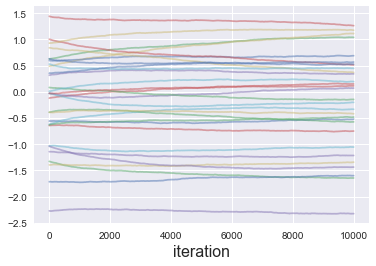

In [218]:
# Not sure this is doing what we want...
figsize = (8,3); fontsize = 16;
f, ax = plt.subplots(1,1)
for i in range(30):
    ax.plot(get_weight_mean(i),alpha=0.5,label=i)
ax.set_xlabel('iteration',fontsize=fontsize);
sns.despine();

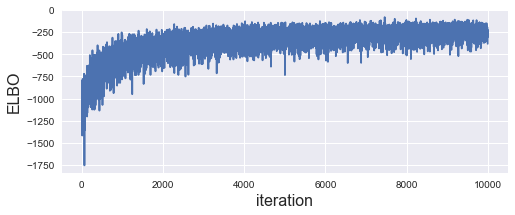

In [220]:
# plotting the training progress
elbo_1 = -advi.hist

figsize = (8,3); fontsize = 16;
f, ax = plt.subplots(1,1,figsize=figsize);

ax.plot(elbo_1,label='1')
ax.set_ylabel('ELBO',fontsize=fontsize)
ax.set_xlabel('iteration',fontsize=fontsize);
sns.despine();

### Assess test performance

In [221]:
# Draw samples from variational posterior (the weights in the network)
n_draws = 500 # > 2k hangs for almost all network sizes on my 2018 MBP -SH
trace = approx.sample(draws=n_draws)

In [222]:
# network at performance on the test set
(n_test,n_input) = X_test.shape
test_x = theano.shared(X_test)
test_y = theano.shared(y_test)
NN_model_test = construct_nn(test_x, test_y, n_input, n_output, n_test, n_hidden_1=128)
n_samples = 100
with NN_model_test:
    ppc_test = pm.sample_ppc(trace, samples=n_samples)

100%|██████████| 100/100 [00:51<00:00,  1.98it/s]


In [223]:
# Prediction is mode of each
test_y_pred = mode(ppc_test['out'], axis=0).mode[0,:]

mean_test_perf = np.mean(test_y_pred==y_test)
print("Network Test Set Performance: {:f}".format(mean_test_perf))

Network Test Set Performance: 0.771100


### Assess uncertainty by category

In [ ]:
def get_cat_entropy(X_test, y_test, ppc_test):
    (n_test,n_input) = X_test.shape
    n_output = 10
    n_samples = np.shape(ppc_test['out'])[0]
    one_hot = np.zeros((n_samples, n_test, n_output))
    for i in range(n_samples):
        one_hot[i][np.arange(n_test), ppc_test['out'][i]] = 1
    histograms = np.sum(one_hot, axis=0)

    cat_hist = np.zeros((n_output, n_output))
    cat_entropy = np.zeros(n_output)
    for i in range(n_output):
        cat_hist[i,:] = np.sum(histograms[y_test == i], axis=0)
        cat_entropy[i] = sp.stats.entropy(cat_hist[i,:])
    return one_hot, cat_hist, cat_entropy

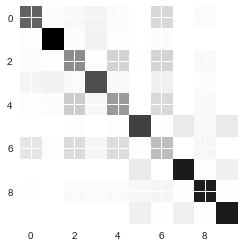

[ 1.30418384  0.66836417  1.39328416  1.2719152   1.48384704  1.07932491
  1.72700762  0.76639405  1.01987266  0.8133666 ]


In [225]:
one_hot, cat_hist, cat_entropy = get_cat_entropy(X_test, y_test, ppc_test)
plt.imshow(cat_hist)
plt.show()
print(cat_entropy)

one layer 128 neurons
10,000 - 77%
40,000 - 81%

## Assess test performance as a function of number of training data points

Before moving on with active learning, I want to get a sense of how test set performace depends on the number of training samples. It would be pretty slow to look at this with out pymc3 model, but we can use Adam optimization in tensorflow to get an idea of the learning curve on an ANN trained with SGD. 

In [135]:
from tensorflow import keras

def tf_model(X_train, y_train):
    model = keras.Sequential([
        keras.layers.Dense(128, activation=tf.nn.tanh),
        keras.layers.Dense(n_output, activation=tf.nn.softmax)
    ])

    model.compile(optimizer=tf.train.AdamOptimizer(), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=5)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    
    return test_acc
    
test_acc = tf_model(X_train, y_train)
print('Test accuracy:', test_acc)

Epoch 1/5
60000/60000 [==============================] - 8s 136us/step - loss: 0.4770 - acc: 0.8297
Epoch 2/5
60000/60000 [==============================] - 9s 158us/step - loss: 0.3707 - acc: 0.8658
Epoch 3/5
60000/60000 [==============================] - 8s 130us/step - loss: 0.3364 - acc: 0.8769
Epoch 4/5
60000/60000 [==============================] - 7s 123us/step - loss: 0.3147 - acc: 0.8838
Epoch 5/5
10000/10000 [==============================] - 1s 96us/step
Test accuracy: 0.8759


In [145]:
n_samples_vec = [10,20, 30, 40, 50, 70, 100, 150, 200, 500, 1000, 10000, 60000]

n_trials = 5
test_acc_results = np.zeros((len(n_samples_vec), n_trials))
for i, n_samples in enumerate(n_samples_vec):
    print(n_samples)
    for j in range(n_trials):
        X_train_subset, y_train_subset = get_training_subset(X_train, y_train, n_samples)
        test_acc = tf_model(X_train_subset, y_train_subset)
        test_acc_results[i,j] = test_acc

[10, 20, 30, 40, 50, 70, 100, 150, 200, 500, 1000, 10000, 60000]
10
Epoch 1/5
9/9 [==============================] - 2s 239ms/step - loss: 2.4269 - acc: 0.1111
Epoch 2/5
9/9 [==============================] - 0s 684us/step - loss: 1.7624 - acc: 0.4444
Epoch 3/5
9/9 [==============================] - 0s 774us/step - loss: 1.2923 - acc: 0.5556
Epoch 4/5
9/9 [==============================] - 0s 822us/step - loss: 0.9105 - acc: 1.0000
Epoch 5/5
10000/10000 [==============================] - 2s 208us/step
Epoch 1/5
9/9 [==============================] - 2s 231ms/step - loss: 2.4940 - acc: 0.2222
Epoch 2/5
9/9 [==============================] - 0s 754us/step - loss: 1.9537 - acc: 0.4444
Epoch 3/5
9/9 [==============================] - 0s 630us/step - loss: 1.5194 - acc: 0.4444
Epoch 4/5
9/9 [==============================] - 0s 797us/step - loss: 1.1550 - acc: 0.8889
Epoch 5/5
10000/10000 [==============================] - 2s 204us/step
Epoch 1/5
9/9 [==============================] - 2s 24

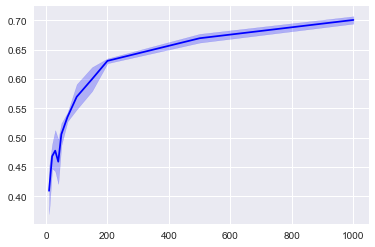

In [182]:
mean_perf = np.mean(test_acc_results, axis=1)
std_perf = np.std(test_acc_results, axis=1)
num_points_plot = 11
plt.plot(n_samples_vec[:num_points_plot], mean_perf[:num_points_plot], c='blue')
plt.fill_between(n_samples_vec[:num_points_plot], mean_perf[:num_points_plot]+std_perf[:num_points_plot], mean_perf[:num_points_plot]-std_perf[:num_points_plot], color='blue', alpha=.25)
plt.show()

The relationship between the number of training data points and test set performance is highly nonlinear. We see a large jump in performance between 10 and 200 training data points, and then a linear increase from then on. With this model, we don't reach assymptotic performance even with the full dataset (though this might not be true if we increase the number of iterations). Since the performance curve is already very steep at the beginning of learning, I am not sure that we will see a large improvement with active learning.

## Active Learning

Functions for getting subset (balanced)

In [136]:
def get_training_subset(X_train, y_train, n_samples):
    (n_train, n_input) = np.shape(X_train)
    n_cat = np.max(y_train)
    if n_train == n_samples:
        return X_train, y_train
    # make n_samples a multiple of 10 for ease of balancing the dataset
    n_cat_samples = int(n_samples/10)
    # get appropraite number of samples from each category
    cat_ind = list()
    ind_array = np.arange(n_train)
    for cat in range(n_cat):
        cat_ind = np.append(cat_ind, np.random.choice(ind_array[y_train == cat], size=n_cat_samples, replace=False))
    np.random.shuffle(cat_ind)
    X_train_subset = X_train[cat_ind.astype(int)]
    y_train_subset = y_train[cat_ind.astype(int)]
    return X_train_subset, y_train_subset
        
def get_training_subset_prop(n_samples, p_vals, n_input):
    (n_train, n_input) = np.shape(X_train)
    n_cat = np.max(y_train)
    # make n_samples a multiple of 10 for ease of balancing the dataset
    n_cat_samples = np.random.multinomial(n_samples, p_vals, size=1)
    # get appropraite number of samples from each category
    cat_ind = list()
    ind_array = np.arange(n_train)
    for cat in range(n_cat):
        cat_ind = np.append(cat_ind, np.random.choice(ind_array[y_train == cat], size=n_cat_samples[i], replace=False))
    print(y_train[cat_ind])
    np.random.shuffle(cat_ind)
    X_train_subset = X_train[cat_ind.astype(int)]
    y_train_subset = y_train[cat_ind.astype(int)]
    return X_train_subset, y_train_subset

### Train Network on subset of data

In [231]:
n_samples = 100
X_train_subset, y_train_subset = get_training_subset(X_train, y_train, n_samples)

NN_model = construct_nn(X_train_subset, y_train_subset, n_input, n_output, n_train_chunks, n_hidden_1=128)

In [ ]:
# convergence not great, use a different method for conv check after:
# https://docs.pymc.io/notebooks/variational_api_quickstart.html
with NN_model:
    advi = pm.ADVI()
    
# After the bayes by BackProp paper!
print(advi.approx.shared_params)

# To better look at convergence, we keep track of parameter mean and std
# ev_mean = advi.approx.mean.eval # callable that returns mean
# ev_std = advi.approx.std.eval # callable that returns std
# tracker = pm.callbacks.Tracker(mean=ev_mean,std=ev_std)
# print(tracker.whatchdict)

n_approx_iter = 10000
with NN_model:
    approx = advi.fit(n=n_approx_iter, callbacks=[tracker])

{'mu': mu, 'rho': rho}


Average Loss = 5,633.3:  72%|███████▏  | 7194/10000 [02:18<01:04, 43.76it/s]

In [172]:
# get_weight_mean = lambda i : [t[i] for t in tracker['mean']]
# get_weight_stds = lambda i : [t[i] for t in tracker['std']]

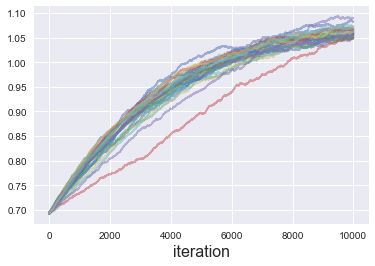

In [173]:
# Not sure this is doing what we want...
figsize = (8,3); fontsize = 16;
f, ax = plt.subplots(1,1)
for i in range(30):
    ax.plot(get_weight_stds(i),alpha=0.5,label=i)
ax.set_xlabel('iteration',fontsize=fontsize);
sns.despine();

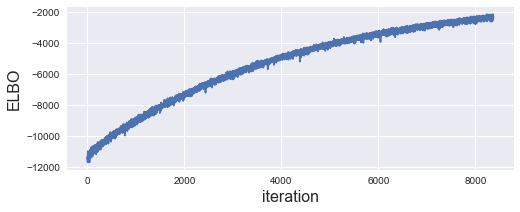

In [174]:
# plotting the training progress
elbo_1 = -advi_chunk.hist

figsize = (8,3); fontsize = 16;
f, ax = plt.subplots(1,1,figsize=figsize);

ax.plot(elbo_1,label='1')
ax.set_ylabel('ELBO',fontsize=fontsize)
ax.set_xlabel('iteration',fontsize=fontsize);
sns.despine();

In [175]:
# Draw samples from variational posterior (the weights in the network)
n_draws = 500 # > 2k hangs for almost all network sizes on my 2018 MBP -SH
trace = approx.sample(draws=n_draws)

In [176]:
# network at performance on the test set
(n_test,n_input) = X_test.shape
test_x = theano.shared(X_test)
test_y = theano.shared(y_test)
NN_model_test = construct_nn(test_x, test_y, n_input, n_output, n_test, n_hidden_1=128)
n_samples = 100
with NN_model_test:
    ppc_test = pm.sample_ppc(trace, samples=n_samples)

100%|██████████| 100/100 [00:53<00:00,  1.95it/s]


In [184]:
# Prediction is mode of each
test_y_pred = mode(ppc_test['out'], axis=0).mode[0,:]

mean_test_perf = np.mean(test_y_pred==y_test)
print("Network Test Set Performance: {:f}".format(mean_test_perf))

Network Test Set Performance: 0.579400


1. check uncertainty on each category
2. see choose next batch of those categories (or proportional to that)

### Evaluate uncertainty within each category

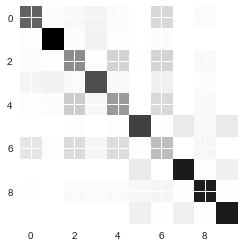

[ 1.30418384  0.66836417  1.39328416  1.2719152   1.48384704  1.07932491
  1.72700762  0.76639405  1.01987266  0.8133666 ]


In [226]:

one_hot, cat_hist, cat_entropy = get_cat_entropy(X_test, y_test, ppc_test)
plt.imshow(cat_hist)
plt.show()
print(cat_entropy)
# # aggregate data by category
# cat_hist = np.zeros((n_output, n_output))
# cat_entropy = np.zeros(n_output)
# for i in range(n_output):
#     cat_hist[i,:] = np.sum(one_hot[y_test == i], axis = (0,2))
#     cat_entropy[i] = sp.stats.entropy(cat_hist[i,:])
# print(cat_entropy/np.sum(cat_entropy))
# plt.imshow(hist/np.sum(hist, axis=1))
# plt.show()

In [186]:
import scipy as sp
test = sp.stats.entropy(histograms[0])
print(test)

1.28301998021


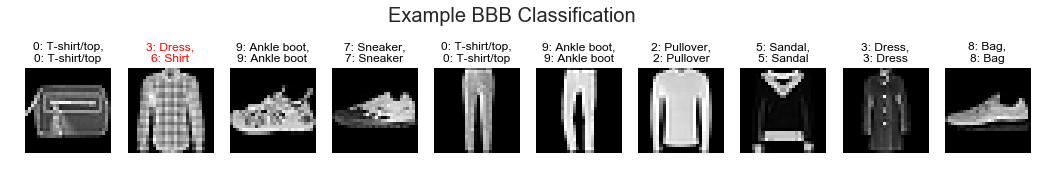

In [20]:
# PLot random subset of images
n_plot_samples = 10
rand_samps = np.random.choice(X_test.shape[0],size=n_plot_samples)

figsize = (18,3); fontsize = 16;
f, axs = plt.subplots(1, n_plot_samples, figsize=figsize);

for rs,ax in zip(rand_samps,axs):
    ax.imshow(imgvec2img(X_train[rs]),cmap='gray');
    tl = "{}: {},\n{}: {}".format(test_y_pred[rs],label_dict[test_y_pred[rs]],y_test[rs],label_dict[y_test[rs]])
    if test_y_pred[rs] == y_test[rs]:
        ax.set_title(tl,color='k');
    else:
        ax.set_title(tl,color='r');
    ax.axis('off');
    sns.despine();
    
f.suptitle("Example BBB Classification",fontsize=fontsize+4);